# Pokemon Data Analysis

Using [PokéAPI](https://pokeapi.co/), I will create a data pipeline in python to extract and transform data about Pokémon in a MySQL database. From there, I’ll analyse the different aspects of the data in python and SQL

In [3]:
import pokemon_pipline as pk
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Data Pipeline

### 1. Extract and Transform Data

Firstly, by using the requests package and a Pokémon object, I will create a list containing the information of every Pokémon, then convert the list into a pandas DataFrame as a more easily accessible form.

In [2]:
pokemon_base_url: str = "https://pokeapi.co/api/v2/pokemon/"
pokemon_list: list = pk.import_pokemon_data_to_list(url = pokemon_base_url)

pokemon_df: pd.DataFrame = pk.list_pokemon_data_to_pd(pokemon_list)
pokemon_df.head()

,pokemonId,name,type1,type2,height,weight,hp,attack,defense,special_attack,special_defense,speed
0,1,bulbasaur,grass,poison,7,69,45,49,49,65,65,45
1,2,ivysaur,grass,poison,10,130,60,62,63,80,80,60
2,3,venusaur,grass,poison,20,1000,80,82,83,100,100,80
3,4,charmander,fire,None,6,85,39,52,43,60,50,65
4,5,charmeleon,fire,None,11,190,58,64,58,80,65,80


In [3]:
pokemon_df.shape

(1025, 12)

I will do the same for Pokémon types, ending up with a DataFrame of Pokémon types and a corresponding ID


In [5]:
type_base_url: str = "https://pokeapi.co/api/v2/type/"
pokemon_types: list = pk.import_type_data_to_list(url = type_base_url)

types_df: pd.DataFrame = pk.list_types_data_to_pd(pokemon_types)
types_df.head()

,pokemonType,typeID
0,normal,0
1,fighting,1
2,flying,2
3,poison,3
4,ground,4


### 2. Load Data to Repository

Can load the Pokémon data in a csv and parquet file

In [ ]:
pk.data_pd_to_csv(pokemon_df)
pk.data_pd_to_parquet(pokemon_df)

However, for more functionality, I will export both DataFrames into a MySQL Database. The following Database and tables are created using mysql.connector. As a Pokémon can have more than one type, the Database is in 2nd normal form to remove duplicate data rows and ensure the data dependencies.       
![Pokémon Database erd](PokemonDB_erd.png)

In [6]:
pk.create_db()
pk.create_db_tables()

Can now populate the database with mysql.connector, sqlalchemy and pandas, making sure to insert the table data in the right order.    
This will only work if all the tables are empty, otherwise the data insertion will fail


In [7]:
#if the tables are not empty
#pk.reset_db_table("all")

#insert pokemon data
pk.insert_pokemon_data_to_db(pokemon_df)

#insert type data
pk.insert_types_data_to_db(types_df)

# insert many to many table data
pk.insert_many_many_data_to_db(pokemon_df,types_df)

## Data Analysis

With the data in the database, the analysis can begin. There are three main questions I want to answer with the dataset:    
1.	How are Pokémon types distributed among Pokémon species?    
2.	Does a Pokémon’s type affect its height and weight?    
3.	Does a Pokémon’s type influence its stats?    
To do this, I will query the data using sqlalchemy and pandas. This allows it to be visualised with matplotlib and draw my conclusions from it.


In [4]:
engine = create_engine(pk.SQL_ALCHEMY_CON_STRING)

### 1. Pokémon types

The Pokémon world is diverse, with all Pokémon being categorised into 18 different types. But these types are not distributed uniformly among the species, with some types being more numerous than others. In the real world, insects make the largest percentages of the world’s species. If the Pokémon world was representative of the real one, bug type would be overwhelmingly the most popular type.

In [5]:
# The numebr of pokemon per type

number_of_pokemone_per_type: str = \
"""
    SELECT 
        t.pokemonType type, 
        count(distinct p.pokemonId) amount
    FROM pokemon p
    inner Join pokemontypes pt
        on p.pokemonId = pt.pokemonId
    join types t
        on t.typeId = pt.typeId
    group by t.pokemonType
    order by amount desc;
"""

In [6]:
df_pokemon_per_type =pd.read_sql(number_of_pokemone_per_type, engine)
df_pokemon_per_type.shape

(18, 2)

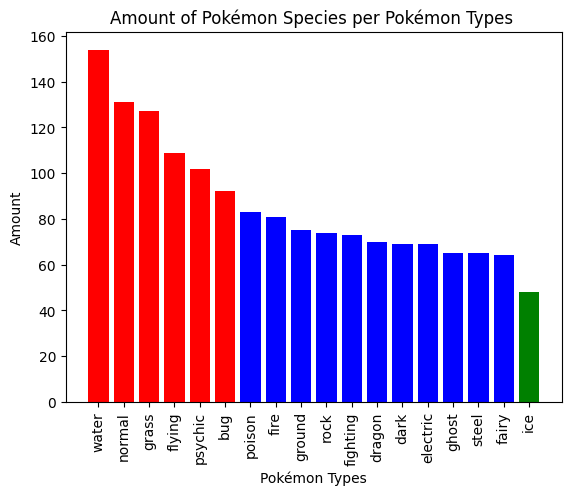

In [7]:
x = df_pokemon_per_type["type"]
y = df_pokemon_per_type ["amount"]

upper_third: int = 6
lower_third: int = 17

fig, ax = plt.subplots()

plt.bar(x[0:upper_third],y[0:upper_third], color = 'red')
plt.bar(x[upper_third:],y[upper_third:], color = 'blue')
plt.bar(x[lower_third:],y[lower_third:], color = 'green')

plt.title("Amount of Pokémon Species per Pokémon Types ")
plt.xlabel("Pokémon Types")
plt.ylabel("Amount")
plt.xticks(rotation=90)

plt.show()

In [14]:
df_pokemon_per_type["amount"].describe()

count     18.000000
mean      86.166667
std       27.931113
min       48.000000
25%       69.000000
50%       74.500000
75%       99.500000
max      154.000000
Name: amount, dtype: float64

In [6]:
df_pokemon_per_type["counter"] = range(1, len(df_pokemon_per_type)+1)

    

In [7]:
df_pokemon_per_type.head()

,type,amount,counter
0,water,154,1
1,normal,131,2
2,grass,127,3
3,flying,109,4
4,psychic,102,5


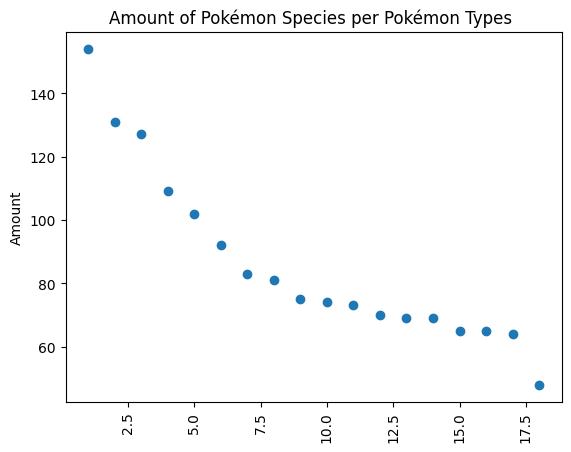

In [8]:
x = df_pokemon_per_type["counter"]
y = df_pokemon_per_type ["amount"]

upper_third: int = 5
lower_third: int = 13

fig, ax = plt.subplots()

plt.scatter(x,y)


plt.title("Amount of Pokémon Species per Pokémon Types ")
plt.ylabel("Amount")
plt.xticks(rotation=90)

plt.show()

<bound method Figure.show of <Figure size 1000x700 with 1 Axes>>

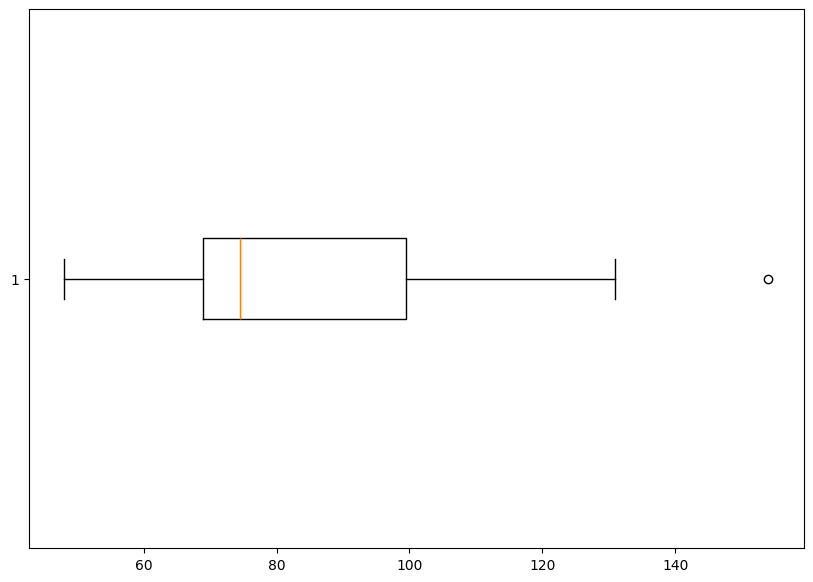

In [18]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(y,vert = 0)
fig.show

(analysis)

Some Pokémon have two types to better describe their characteristics and traits, adding to the potential diversity. The original set counted these double type Pokémon twice. So, to see how these double types contribute to the total type distribution, the most popular double types are queried.

In [6]:
type_pairing_str: str = \
"""
    SELECT  
        t1.pokemonType type1,
        t2.pokemonType type2,
        count(p1.typeId) amount
    from pokemontypes p1
    join pokemontypes p2
        on p1.pokemonId = p2.pokemonId and p1.typeId > p2.typeId
    join types t1
        on t1.typeId = p1.typeId
    join types t2
        on t2.typeId = p2.typeId
    group by p1.typeId, p2.typeId
    order by amount desc;
"""

In [7]:
df_type_pairing = pd.read_sql(type_pairing_str, engine)
df_type_pairing.shape

(136, 3)

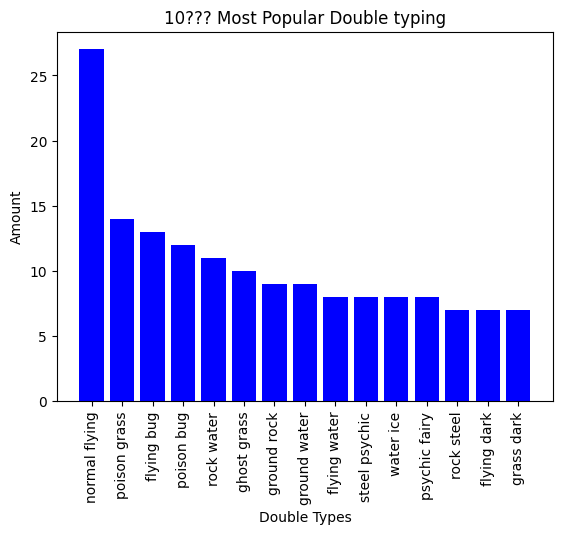

In [8]:
x = df_type_pairing["type2"] + " " + df_type_pairing["type1"]
y = df_type_pairing["amount"]

upper_limit: int = 15

fig, ax = plt.subplots()

plt.bar(x[0:upper_limit],y[0:upper_limit], color = 'blue')
# plt.bar(x[lower_limit:],y[lower_limit:], color = 'green')

plt.title("10??? Most Popular Double typing")
plt.xlabel("Double Types")
plt.ylabel("Amount")
plt.xticks(rotation=90)

plt.show()

(analysis)


### Height and Weight

Height and weight of all pokemon

In [9]:
height_weight_all_pokemon_str: str = \
"""
    Select height, weight 
    from pokemon;
"""

In [10]:
df_height_weight_all = pd.read_sql(height_weight_all_pokemon_str, engine)
df_height_weight_all.shape

(1025, 2)

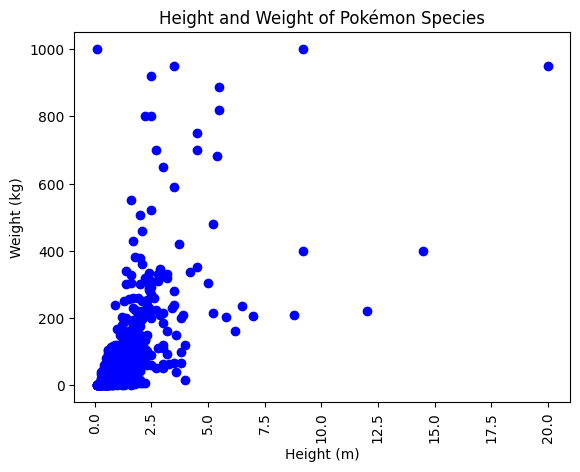

In [11]:
x = df_height_weight_all["height"] * 0.1
y = df_height_weight_all["weight"] * 0.1

upper_limit: int = 15

fig, ax = plt.subplots()

plt.scatter(x,y, color = 'blue')
# plt.bar(x[lower_limit:],y[lower_limit:], color = 'green')

plt.title("Height and Weight of Pokémon Species")
plt.xlabel("Height (m)")
plt.ylabel("Weight (kg)")
plt.xticks(rotation=90)

plt.show()

mean and std of the height and weight for each type

In [12]:
mean_height_weight_per_type_str: str = \
"""
    with cte as(
    	SELECT t.pokemonType, pt.pokemonId
    	FROM types t
    	join pokemontypes pt
    	on t.typeId = pt.typeId
        )
        
    select 
        ROUND(avg(p.height),2) mean_height, ROUND(STD(p.height),2) sd_height,
        ROUND(avg(p.weight),2) mean_weight, ROUND(STD(p.weight),2) sd_weight,
        c.pokemonType
    from pokemon p
    join cte c
    on p.pokemonId = c.pokemonId
    group by c.pokemonType
    order by mean_height Desc, mean_weight Desc;
"""

In [13]:
df_mean_height_weight_type = pd.read_sql(mean_height_weight_per_type_str, engine)
df_mean_height_weight_type.head()

,mean_height,sd_height,mean_weight,sd_weight,pokemonType
0,22.86,25.65,1642.87,2053.19,dragon
1,15.64,15.03,1292.76,1809.28,ground
2,15.62,16.97,1621.71,2164.94,steel
3,14.58,8.03,1319.56,1649.41,ice
4,13.85,6.16,797.11,850.63,fighting


do a box plot or historgram

do a couple for certain types    
ones with largest and smallest sd

In [14]:
height_weight_fire_sql: str =\
"""
    with cte as(
    	SELECT t.pokemonType, pt.pokemonId
    	FROM types t
    	join pokemontypes pt
    	on t.typeId = pt.typeId
        )
    select p.height , p.weight, c.pokemonType
    from pokemon p
    join cte c
    on p.pokemonId = c.pokemonId
    where  c.pokemonType = "dragon"
    order by p.height Desc,  p.weight Desc;
"""

In [15]:
df_height_weight_fire = pd.read_sql(height_weight_fire_sql, engine)
df_height_weight_fire.head()

,height,weight,pokemonType
0,200.0,9500.0,dragon
1,70.0,2065.0,dragon
2,55.0,8880.0,dragon
3,54.0,6830.0,dragon
4,52.0,4800.0,dragon


### Stats

Overall Stats of all pokemon

In [16]:
stats_all_pokemon_str: str = \
"""
    select hp, attack,
     defense, special_attack,
     special_defense, speed, 
     (attack+defense) as 'physical_stats',
     (special_attack+special_defense) as 'special_stats',
     (hp+attack+defense+special_attack+special_defense+speed) as 'overall_stats'
    from pokemon;
"""

In [17]:
df_stats_all_pokemon = pd.read_sql(stats_all_pokemon_str, engine)
df_stats_all_pokemon.head()

,hp,attack,defense,special_attack,special_defense,speed,physical_stats,special_stats,overall_stats
0,45,49,49,65,65,45,98,130,318
1,60,62,63,80,80,60,125,160,405
2,80,82,83,100,100,80,165,200,525
3,39,52,43,60,50,65,95,110,309
4,58,64,58,80,65,80,122,145,405


Mean and std of stats for each pokemon type

In [18]:
mean_stats_per_type_str: str = \
"""
    WITH cte AS(
    	SELECT pt.pokemonId, t.pokemonType
        from types t 
        join pokemontypes pt
        on pt.typeId = t.typeId
    ),
    cte2 as(
        select pokemonId,
             (attack+defense) as 'physical_stats',
             (special_attack+special_defense) as 'special_stats',
             (hp+attack+defense+special_attack+special_defense+speed) as 'overall_stats'
        from pokemon)
    SELECT 
        c.pokemonType,
        ROUND(avg(p.hp),2) mean_hp, ROUND(STD(p.hp),2) sd_hp,
        ROUND(avg(p.attack),2) mean_attack, ROUND(STD(p.attack),2) sd_attack,
        ROUND(avg(p.defense),2) mean_defense, ROUND(STD(p.defense),2) sd_defense,
        ROUND(avg(p.special_attack),2) mean_special_attack, ROUND(STD(p.special_attack),2) sd_special_attack,
        ROUND(avg(p.special_defense),2) mean_special_defense, ROUND(STD(p.special_defense),2) sd_special_defense,
        ROUND(avg(p.speed),2) mean_speed, ROUND(STD(p.speed),2) sd_speed,
        ROUND(avg(c2.physical_stats),2) mean_physical_stats, ROUND(STD(c2.physical_stats),2) sd_physical_stats,
        ROUND(avg(c2.special_stats),2) mean_special_stats, ROUND(STD(c2.special_stats),2) sd_special_stats,
        ROUND(avg(c2.overall_stats),2) mean_overall_stats, ROUND(STD(c2.overall_stats),2) sd_overall_stats
    from pokemon p
    join cte c
        on c.pokemonId = p.pokemonId
    join cte2 c2
        on c2.pokemonId = p.pokemonId
    group by c.pokemonType
    order by mean_hp Desc;
    """

In [19]:
df_mean_stats_per_type = pd.read_sql(mean_stats_per_type_str, engine)
df_mean_stats_per_type.head()

,pokemonType,mean_hp,sd_hp,mean_attack,sd_attack,mean_defense,sd_defense,mean_special_attack,sd_special_attack,mean_special_defense,sd_special_defense,mean_speed,sd_speed,mean_physical_stats,sd_physical_stats,mean_special_stats,sd_special_stats,mean_overall_stats,sd_overall_stats
0,dragon,84.07,32.58,94.00,26.86,83.04,24.84,87.20,34.08,78.27,26.04,78.17,28.24,177.04,44.54,165.47,54.63,504.76,123.69
1,ice,80.08,27.00,82.27,29.49,75.73,32.23,74.94,26.83,75.19,29.71,65.44,27.40,158.00,53.82,150.13,50.13,453.65,106.12
2,fighting,77.75,23.52,104.33,25.17,76.37,24.48,63.59,25.39,69.70,22.45,75.40,27.19,180.70,42.87,133.29,37.00,467.14,100.23
3,ground,77.05,26.90,88.44,27.09,85.45,33.05,57.51,21.52,64.76,21.34,58.47,25.58,173.89,51.20,122.27,38.70,431.68,103.77
4,normal,76.56,33.87,74.01,28.34,60.30,22.13,59.13,25.33,63.94,23.70,68.91,26.75,134.31,46.69,123.07,43.94,402.84,108.51
